## Dataset. model_dataset
<br>
<img src="./images/model_dataset.png"/>

Part explanation for the columns:  
1. label_group (obeject): 4 groups of resonse to offers
    - 'none_offer'
    - 'no_care'
    - 'tried'
    - 'effective_offer'
2. label_seg (int): 12 segments based on age and gender
    - values: 1 ... 12  <br>  
  
(More details in <u>2_heuristic_exploration.ipynb</u>)

###  <u>10 Kinds</u> of offer_id
| offer_id #| type | duration | requirement | reward |
|:-| :-| :-:|:-:|:-:|
| 0 | bogo | 7 | 10 | 10 |
| 1 | bogo | 5 | 10 | 10 |
| 2 | infomational | 4 | - | - |
| 3 | bogo | 7 | 5 | 5 |
| 4 | discount | 10 | 20 | 5 |
| 5 | discount | 7 | 7 | 3 |
| 6 | discount | 10 | 10 | 2 |
| 7 | informational | 3 | - | - |
| 8 | bogo | 5 | 5 | 5 |
| 9 | discount | 7 | 10 | 2 |

### <u>12 Segements</u> based on 'age' and 'gender'
<br>
    
|Segment #| Age Group (edge included)<br> (Experiment in 2018) | Gender | 
|---| --- | --- | 
|1| Millenials(-21 & 22-37) | M | 
|2| Millenials(-21 & 22-37) | F | 
|3| Millenials(-21 & 22-37) | O | 
|4| Gen X(38-53) | M|
|5| Gen X(38-53) | F|
|6| Gen X(38-53) | O|
|7| Baby Boomer(54-72) | M|
|8| Baby Boomer(54-72) | F|
|9| Baby Boomer(54-72) | O|
|10| Silent(73-90 & 91+) | M|
|11| Silent(73-90 & 91+) | F|
|12| Silent(73-90 & 91+) | O|

### <u>4 Groups</u> of possible responsiveness to offer
<br>

|Group| received | viewed |valid completed | transaction amount |Scenario |
| :-| :-: | :-:| :-: | :-: | :- |
|1.none_offer| 0 | 0 | 0 | |haven't received the offer |
|2.no_care | 1 | 0 | - | |received but not viewed.<br> regarded as no_care|
|| 1 | 1 | 0 | =0.0 | received, viewed but no transaction |
|| 1 | 1 | 1<br>viewed after completed |  | received, but completed unintentionally |
|3.tried| 1 | 1 | 0 | >0.0|received, viewed, have transaction |
|4.effctive_offer | 1 | 1 | 1<br>viewed before completed | | viewed before completed,  effctive offer|

# <a class="anchor" id="Start">Table of Contents</a>

I. [Feature Engineer](#1)<br>
II.[Build model Pipeline](#2)<br>
III.[Explore intersting Questions](#3)

    - Q3.1 Offer prepared to sent to a person, is this offer effective?
    - Q3.2 Offer already sent to a person, is this offer effective?
    - Q3.3 Given a person, recommend an offer with the most effctivity?
IV.[Build Neural Network for Regeression](#4)<br>
[References](#References)

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from datetime import date
from collections import defaultdict

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

model_dataset_raw = pd.read_csv('./data_generated/model_raw_dataset.csv', dtype={'offer_id': str})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [3]:
from sklearn.pipeline import Pipeline
import pickle

In [74]:
from sklearn.multioutput import MultiOutputClassifier

## <a class="anchor" id="1">[I. Feature Engineer](#Start)</a>

### 1. Add features
- Total transactions amount of individuals `'amount_total'`
- Count of offers received of individuals  `'offer_received_cnt'`

In [4]:
# Load in transactions dataset

# wrangled transcript with updated information of offer
transcript_offer = pd.read_csv('./data_generated/wrangled_transcript_offer.csv', dtype={'person': int})
# recover to original dataset: index is the same
transcript_offer.index = transcript_offer.iloc[:, 0].values
del transcript_offer['Unnamed: 0']

In [5]:
transcript_amount = transcript_offer.groupby('person').sum()['amount']
offer_received_cnt = model_dataset_raw.groupby(['person']).count()['offer_id']
persons = transcript_amount.index.tolist()

for person in persons:
    is_person = (model_dataset_raw.person == person)
    model_dataset_raw.loc[is_person,'amount_total'] = transcript_amount.loc[person]
    model_dataset_raw.loc[is_person,'offer_received_cnt'] = offer_received_cnt.loc[person]

In [6]:
model_dataset = model_dataset_raw.copy()

In [7]:
model_dataset.groupby('label_group').count()

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,mobile,social,web,gender,age,income,member_days,label_seg,amount_total,offer_received_cnt
label_group,,,,,,,,,,,,,,,,,,,,,
effctive_offer,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,...,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826
no_care,31613,31613,31613,14972,22859,13581,31613,31613,31613,31613,...,31613,31613,31613,31613,31613,31613,31613,31613,31613,31613
none_offer,5,5,0,0,5,0,5,5,0,0,...,0,0,0,5,5,5,5,5,5,5
tried,8062,8062,8062,8062,8062,0,8062,8062,8062,8062,...,8062,8062,8062,8062,8062,8062,8062,8062,8062,8062


**FOUND:**
1. The 5 person in group `none_offer` will be droped, so that there is no more NaNs in the target columns in `model_dataset` 

In [8]:
is_dataset_kepp = (model_dataset.label_group != 'none_offer')
model_dataset = model_dataset[is_dataset_kepp]

### 2. One-hot code for target obejects
- gender
- label_group

In [9]:
gender_onehot = pd.get_dummies(model_dataset['gender'], prefix='gender')
label_group_onehot = pd.get_dummies(model_dataset['label_group'], prefix='group')
offer_id_onehot =  pd.get_dummies(model_dataset['offer_id'], prefix='offer')

In [10]:
model_dataset = pd.concat([model_dataset, gender_onehot, label_group_onehot, offer_id_onehot], axis=1)

### 3. Features of time
1. Time features
    - 'time_received'
    - 'time_viewed'
    - 'time_transaction'
    - 'time_completed'
2. Transform the time_transaction to transaction_cnt
3. Fill the NaNs with 0

In [11]:
model_dataset[(model_dataset.time_transaction.isin(['-1']))].offer_id.unique()  #-1标签 只对应offer_id.isin(['2','7']) 

array(['2', '7'], dtype=object)

In [12]:
def transform_transaction_cnt(dataset):
    # group of offer_id=='2' '7'
    # group of transaction = -1
    # group of transaction with ','
    
    dataset['time_transaction'] = dataset['time_transaction'].apply(lambda x: len(str(x).split(','))-1)
    
    is_group_info = (dataset.offer_id.isin(['2', '7']) & (dataset.label_effective_offer==1))
    dataset.loc[is_group_info, 'time_transaction'] = 1
    
    return dataset

model_dataset = transform_transaction_cnt(model_dataset)

In [13]:
model_dataset.rename(columns={'time_transaction': 'transaction_cnt'}, inplace=True)

# drop the useless columns for modeling
model_dataset.drop(['label_effective_offer'], axis=1, inplace=True)

values = {'time_viewed': 0.0, 'time_completed': 0.0} #time_viewed: 49860 non-null, time_completed: 40407 non-null
model_dataset.fillna(value=values, inplace=True)

model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66505
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   person                66501 non-null  int64  
 1   offer_id              66501 non-null  object 
 2   time_received         66501 non-null  float64
 3   time_viewed           66501 non-null  float64
 4   transaction_cnt       66501 non-null  int64  
 5   time_completed        66501 non-null  float64
 6   amount_with_offer     66501 non-null  float64
 7   reward                66501 non-null  float64
 8   difficulty            66501 non-null  float64
 9   duration              66501 non-null  float64
 10  offer_type            66501 non-null  object 
 11  email                 66501 non-null  float64
 12  mobile                66501 non-null  float64
 13  social                66501 non-null  float64
 14  web                   66501 non-null  float64
 15  gender             

## <a class="anchor" id="2">[II. Build model Pipeline](#Start)</a>

In [14]:
# 方便重启
model_dataset_test = model_dataset.copy()

In [15]:
model_dataset = model_dataset_test

### 1. Select features and target 
[References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)

In [16]:
# Target: label_group
model_dataset['label_group'] = model_dataset['label_group'].replace(['no_care','tried', 'effctive_offer'],['0','1','1'])
model_dataset = model_dataset.astype({'label_group': int})

model_dataset.groupby('label_group').count()  
# 31613	 VS 34888: The distribution of the targets seems balanced

,person,offer_id,time_received,time_viewed,transaction_cnt,time_completed,amount_with_offer,reward,difficulty,duration,...,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
label_group,,,,,,,,,,,,,,,,,,,,,
0,31613,31613,31613,31613,31613,31613,31613,31613,31613,31613,...,31613,31613,31613,31613,31613,31613,31613,31613,31613,31613
1,34888,34888,34888,34888,34888,34888,34888,34888,34888,34888,...,34888,34888,34888,34888,34888,34888,34888,34888,34888,34888


In [35]:
def select_features_target(df, target_cols, keep_cols):
    '''
    INPUT:
    - df(DataFrame): dataset include all possible features and target
    - target_cols: 
        a column name(str) or more columns names(list of str)
    - keep_cols(list): list of columns names as features
    
    OUTPUT:
    - 
    '''
    # df[[]] is DataFrame
    target = df[target_cols] #np.array()
    
    drop_cols = np.setdiff1d(df.columns, keep_cols)
    features = df.drop(drop_cols, axis=1)
    
    return features, target

### 2. prepare model pipeline
[References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)

In [18]:
def select_clf(pickle_path, clf_ls, features, target, test_size=0.20, random_state=9):
    '''
    OUTPUT:
    - results(dict): 'model', 'train_time', 'pred_time', 'train_score', 'test_score'
    '''
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    
    results = defaultdict()
    visual_results = pd.DataFrame(columns=['model', 'train_time', 'test_time',
                                         'train_score', 'test_score'])
    #models = defaultdict()
    #report_ls = []
    
    
    for classifier in clf_ls:
        pipe = Pipeline(steps=[('preprocessor', StandardScaler()),
                               ('clf', classifier)])
                           
        start_train = time()
        model = pipe.fit(X_train, y_train)
        end_train = time()
        results['train_time'] = end_train-start_train
        
        # predict in train set
        pred_train = model.predict(X_train)
        
        # predict in test set and Calculate the time
        start_test = time()
        pred_test = model.predict(X_test)
        end_test = time()
        results['test_time'] = end_test-start_test
    
        # add training accuracy to results
        # what is the score？
        results['train_score']=model.score(X_train,y_train)
    
        #add testing accuracy to results
        results['test_score']=model.score(X_test,y_test)
        
        
        print("{} trained on {} samples.".format(classifier.__class__.__name__, len(y_train)))
        print("Train time: {}s".format(results['train_time']))
        print("Test time: {}s".format(results['test_time']))
        print("MSE_train: %.4f" % mean_squared_error(y_train,pred_train))
        print("MSE_test: %.4f" % mean_squared_error(y_test,pred_test))
        print("Training accuracy: %.4f" % results['train_score'])
        print("Test accuracy: %.4f" % results['test_score'])
        
        # output the report
        report = classification_report(y_test, pred_test,digits=4) #output_dict=True
        print(report)
                # df_report = pd.DataFrame(report).transpose()
                # report_ls.append(df_report)
        
        # for scaler value need an index
        new_model = pd.Series([classifier.__class__.__name__, results['train_time'],
                            results['test_time'], results['train_score'], results['test_score']],
                           index=visual_results.columns)
        visual_results = visual_results.append(new_model, ignore_index=True)
        
        #models[classifier.__class__.__name__] = model
        #覆盖之后只写入了最后一个模型
        with open(pickle_path, "wb") as f:  
                pickle.dump(model, f)
        
    return visual_results #,report_ls

In [21]:
def model_select_param(classifier, param_grid, features, target, test_size=0.20, random_state=9):
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    
    pipe = Pipeline(steps=[('preprocessor', StandardScaler()),
                        ('clf', classifier)])
    CV = GridSearchCV(pipe, param_grid, n_jobs= 1)
    
    results = defaultdict()
    
    start = time()
    CV.fit(X_train, y_train) 
    end = time()
    
    # Attribute: best_estimator_  best_params_  best_score_
    results['model'] = CV
    results['train_time'] = end - start
    
    # predict in train set
    pred_train = CV.predict(X_train)

    # predict in test set and Calculate the time
    start_test = time()
    pred_test = CV.predict(X_test)
    end_test = time()
    results['test_time'] = end_test-start_test

    # add training accuracy to results
    # what is the score？
    results['train_score']=CV.score(X_train,y_train)

    #add testing accuracy to results
    results['test_score']=CV.score(X_test,y_test)

    print("{} trained on {} samples.".format(CV.best_estimator_, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train, pred_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test, pred_test))
    print("Training accuracy: %.4f" % results['train_score'])
    print("Test accuracy: %.4f" % results['test_score'])
    print(classification_report(y_test, pred_test,digits=4))

    return results

## <a class="anchor" id="3">[III. Explore intersting Questions](#Start)</a>

### Q3.1 Offer prepared to sent to a person, is this offer effective?

1. Dataset<br>
Data in the group as follows in label_group:
    - no_care
    - tried
    - effective_offer

2. Target   

| Target | Value | Meaning |
| :- | :-: | :- |
| label_group | 0 | person doesn't care the offer |
|       | 1 | Within the duration of offer, tried or completed the transactions|

3. Features

| (Number: default 1)Features | Select reason |
| :- | :- |
| age | basic info about person |
| income | basic info about person |
| member_days | basic info about person |
| (3)gender_ | basic info about person<br>(3 kinds of 0-1 variables) |
| (10)offer_ | info about offer<br>(10 kinds of 0-1 variables) |
| amount_total | amount paid of all transactions |
| offer_received_cnt | number of all received offers |
| time_received | receive time for this offer |


In [22]:
target_cols = 'label_group'

keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
            'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9',
             'amount_total', 'offer_received_cnt','time_received']
           
features, target = select_features_target(model_dataset, target_cols, keep_cols)

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

# test for ideal with group infos
pickle_path = './models_effct_1.pckl'
results_effct_1 = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


KNeighborsClassifier trained on 53200 samples.
Train time: 4.211590528488159s
Test time: 11.938185930252075s
MSE_train: 0.1846
MSE_test: 0.3239
Training accuracy: 0.8154
Test accuracy: 0.6761
              precision    recall  f1-score   support

           0     0.6620    0.6505    0.6562      6320
           1     0.6885    0.6993    0.6939      6981

    accuracy                         0.6761     13301
   macro avg     0.6752    0.6749    0.6750     13301
weighted avg     0.6759    0.6761    0.6760     13301

DecisionTreeClassifier trained on 53200 samples.
Train time: 0.8615069389343262s
Test time: 0.014992475509643555s
MSE_train: 0.0000
MSE_test: 0.3560
Training accuracy: 1.0000
Test accuracy: 0.6440
              precision    recall  f1-score   support

           0     0.6228    0.6359    0.6293      6320
           1     0.6640    0.6513    0.6576      6981

    accuracy                         0.6440     13301
   macro avg     0.6434    0.6436    0.6434     13301
weighted avg

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomForestClassifier trained on 53200 samples.
Train time: 10.75484323501587s
Test time: 0.4717295169830322s
MSE_train: 0.0000
MSE_test: 0.2686
Training accuracy: 1.0000
Test accuracy: 0.7314
              precision    recall  f1-score   support

           0     0.7242    0.7019    0.7129      6320
           1     0.7375    0.7581    0.7476      6981

    accuracy                         0.7314     13301
   macro avg     0.7309    0.7300    0.7303     13301
weighted avg     0.7312    0.7314    0.7311     13301



D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier trained on 53200 samples.
Train time: 3.061246633529663s
Test time: 0.13292455673217773s
MSE_train: 0.2841
MSE_test: 0.2843
Training accuracy: 0.7159
Test accuracy: 0.7157
              precision    recall  f1-score   support

           0     0.6997    0.7038    0.7017      6320
           1     0.7304    0.7265    0.7285      6981

    accuracy                         0.7157     13301
   macro avg     0.7151    0.7152    0.7151     13301
weighted avg     0.7158    0.7157    0.7158     13301



D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier trained on 53200 samples.
Train time: 8.804962635040283s
Test time: 0.03796029090881348s
MSE_train: 0.2675
MSE_test: 0.2711
Training accuracy: 0.7325
Test accuracy: 0.7289
              precision    recall  f1-score   support

           0     0.7147    0.7147    0.7147      6320
           1     0.7417    0.7417    0.7417      6981

    accuracy                         0.7289     13301
   macro avg     0.7282    0.7282    0.7282     13301
weighted avg     0.7289    0.7289    0.7289     13301



In [23]:
results_effct_1

,model,train_time,test_time,train_score,test_score
0,KNeighborsClassifier,4.211591,11.938186,0.815395,0.676115
1,DecisionTreeClassifier,0.861507,0.014992,1.000000,0.644012
2,RandomForestClassifier,10.754843,0.471730,0.999962,0.731374
3,AdaBoostClassifier,3.061247,0.132925,0.715883,0.715736
4,GradientBoostingClassifier,8.804963,0.037960,0.732538,0.728893


### Q3.2 Offer already sent to a person, is this offer effective?

1. Dataset<br>
Data in the group as follows in label_group:
    - no_care
    - tried
    - effective_offer


2. Target   

| Target | Value | Meaning |
| :- | :-: | :- |
| label_group | 0 | person doesn't care the offer |
|       | 1 | Within the duration of offer, tried or completed the transactions|

3. Features

| (Number: default 1)Features | Select reason |
| :- | :- |
| age | basic info about person |
| income | basic info about person |
| member_days | basic info about person |
| (3)gender_ | basic info about person<br>(3 kinds of 0-1 variables) |
| (10)offer_ | info about offer<br>(10 kinds of 0-1 variables) |
| amount_with_offer | amount paid of transactions for this offer |
| amount_total | amount paid of all transactions |
| offer_received_cnt | number of all received offers |
| time_received | receive time for this offer |
| time_viewed | view time for this offer. <br>If not, values 0.0|


In [24]:
# 'group_effctive_offer', 'group_no_care', 'group_tried','transaction_cnt', 'time_completed' has direct information of target classes
target_cols = 'label_group'

keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
            'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9',
             'amount_with_offer', 'amount_total', 'offer_received_cnt',
            'time_received', 'time_viewed']
           
features, target = select_features_target(model_dataset, target_cols, keep_cols)

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

# test for ideal with group infos
pickle_path = './models_rec_1.pckl'
results_rec_1 = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


KNeighborsClassifier trained on 53200 samples.
Train time: 1.4651813507080078s
Test time: 25.648320198059082s
MSE_train: 0.1164
MSE_test: 0.2107
Training accuracy: 0.8836
Test accuracy: 0.7893
              precision    recall  f1-score   support

           0     0.8151    0.7198    0.7645      6320
           1     0.7706    0.8522    0.8093      6981

    accuracy                         0.7893     13301
   macro avg     0.7928    0.7860    0.7869     13301
weighted avg     0.7917    0.7893    0.7880     13301

DecisionTreeClassifier trained on 53200 samples.
Train time: 0.7675607204437256s
Test time: 0.01299285888671875s
MSE_train: 0.0000
MSE_test: 0.1199
Training accuracy: 1.0000
Test accuracy: 0.8801
              precision    recall  f1-score   support

           0     0.8676    0.8823    0.8749      6320
           1     0.8918    0.8781    0.8849      6981

    accuracy                         0.8801     13301
   macro avg     0.8797    0.8802    0.8799     13301
weighted avg

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomForestClassifier trained on 53200 samples.
Train time: 10.088226079940796s
Test time: 0.3388090133666992s
MSE_train: 0.0000
MSE_test: 0.0871
Training accuracy: 1.0000
Test accuracy: 0.9129
              precision    recall  f1-score   support

           0     0.9753    0.8378    0.9014      6320
           1     0.8698    0.9808    0.9220      6981

    accuracy                         0.9129     13301
   macro avg     0.9226    0.9093    0.9117     13301
weighted avg     0.9199    0.9129    0.9122     13301



D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier trained on 53200 samples.
Train time: 3.7498526573181152s
Test time: 0.1779012680053711s
MSE_train: 0.1039
MSE_test: 0.1045
Training accuracy: 0.8961
Test accuracy: 0.8955
              precision    recall  f1-score   support

           0     0.9449    0.8283    0.8828      6320
           1     0.8602    0.9563    0.9057      6981

    accuracy                         0.8955     13301
   macro avg     0.9026    0.8923    0.8943     13301
weighted avg     0.9005    0.8955    0.8948     13301



D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier trained on 53200 samples.
Train time: 10.951734066009521s
Test time: 0.032980918884277344s
MSE_train: 0.0875
MSE_test: 0.0871
Training accuracy: 0.9125
Test accuracy: 0.9129
              precision    recall  f1-score   support

           0     0.9806    0.8331    0.9008      6320
           1     0.8670    0.9851    0.9223      6981

    accuracy                         0.9129     13301
   macro avg     0.9238    0.9091    0.9116     13301
weighted avg     0.9210    0.9129    0.9121     13301



In [25]:
results_rec_1

,model,train_time,test_time,train_score,test_score
0,KNeighborsClassifier,1.465181,25.648320,0.883553,0.789264
1,DecisionTreeClassifier,0.767561,0.012993,1.000000,0.880084
2,RandomForestClassifier,10.088226,0.338809,1.000000,0.912864
3,AdaBoostClassifier,3.749853,0.177901,0.896109,0.895497
4,GradientBoostingClassifier,10.951734,0.032981,0.912500,0.912864


In [44]:
#load model: feature_importances_
with open(r"./models_rec_1.pckl", "rb") as f:
    models = pickle.load(f)


In [47]:
models

Pipeline(memory=None,
         steps=[('preprocessor',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
            

In [53]:
columns = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
            'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9',
             'amount_with_offer', 'amount_total', 'offer_received_cnt',
            'time_received', 'time_viewed']

In [59]:
ss = pd.DataFrame(models['clf'].feature_importances_, index=columns)

In [63]:
ss.T

,age,income,member_days,gender_F,gender_M,gender_O,offer_0,offer_1,offer_2,offer_3,...,offer_5,offer_6,offer_7,offer_8,offer_9,amount_with_offer,amount_total,offer_received_cnt,time_received,time_viewed
0,0.045632,0.472034,0.444402,0.000026,0.001122,0.000281,0.01133,0.0,0.0,0.000022,...,0.000578,0.002093,0.004974,0.000698,0.003657,0.001892,0.003968,0.005208,0.00163,0.000453


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text xticklabel objects>)

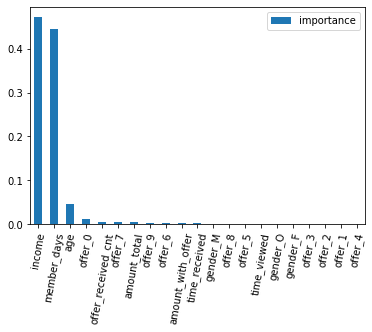

In [73]:
feature_importances = pd.DataFrame(models['clf'].feature_importances_,
                                   index = columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.xticks(rotation=80)

In [52]:
models['clf'].feature_importances_

array([4.56324462e-02, 4.72033781e-01, 4.44402454e-01, 2.55175290e-05,
       1.12150636e-03, 2.80900549e-04, 1.13300054e-02, 0.00000000e+00,
       0.00000000e+00, 2.19228512e-05, 0.00000000e+00, 5.78157431e-04,
       2.09276577e-03, 4.97437464e-03, 6.97948377e-04, 3.65740339e-03,
       1.89181201e-03, 3.96767057e-03, 5.20828150e-03, 1.62964921e-03,
       4.53403179e-04])

### Q3.3 Given a person, recommend an offer with the most effctivity.

定位：只有个人基本信息和汇总的情况，没有针对的offer

1. Dataset<br>
Data in the group as follows in label_group:
    - tried——in this group exists transaction(s)
    - effective_offer


2. Target

| Target | Value | Meaning |
| :- | :-: | :- |
| offer_(10 classes) | 0 | uneffective in this offer_id |
|              | 1 | effective in this offer_id |

3. Features

| (Number: default 1)Features | Select reason |
| :- | :- |
| age | basic info about person |
| income | basic info about person |
| member_days | basic info about person |
| (3)gender_ | basic info about person<br>(3 kinds of 0-1 variables) |
| (10)offer_ | info about offer<br>(10 kinds of 0-1 variables) |
| amount_with_offer | amount paid of transactions for this offer |
| amount_total | amount paid of all transactions |
| offer_received_cnt | number of all received offers |
| time_received | receive time for this offer |
| time_viewed | view time for this offer. <br>If not, values 0.0|

In [26]:
is_group_effective = (model_dataset.label_group==1)  #tried & effctive_offer
model_dataset_input = model_dataset[is_group_effective]

In [43]:
model_dataset_input.groupby('offer_id').count()  #seems the samples is far from enough

,person,time_received,time_viewed,transaction_cnt,time_completed,amount_with_offer,reward,difficulty,duration,offer_type,...,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
offer_id,,,,,,,,,,,,,,,,,,,,,
0,4574,4574,4574,4574,4574,4574,4574,4574,4574,4574,...,4574,4574,4574,4574,4574,4574,4574,4574,4574,4574
1,4645,4645,4645,4645,4645,4645,4645,4645,4645,4645,...,4645,4645,4645,4645,4645,4645,4645,4645,4645,4645
2,1623,1623,1623,1623,1623,1623,1623,1623,1623,1623,...,1623,1623,1623,1623,1623,1623,1623,1623,1623,1623
3,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,...,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340
4,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,...,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686
5,4964,4964,4964,4964,4964,4964,4964,4964,4964,4964,...,4964,4964,4964,4964,4964,4964,4964,4964,4964,4964
6,5351,5351,5351,5351,5351,5351,5351,5351,5351,5351,...,5351,5351,5351,5351,5351,5351,5351,5351,5351,5351
7,2869,2869,2869,2869,2869,2869,2869,2869,2869,2869,...,2869,2869,2869,2869,2869,2869,2869,2869,2869,2869
8,4473,4473,4473,4473,4473,4473,4473,4473,4473,4473,...,4473,4473,4473,4473,4473,4473,4473,4473,4473,4473


In [96]:
# 'group_effctive_offer', 'group_no_care', 'group_tried','transaction_cnt', 'time_completed' has direct information of target classes
target_cols = ['offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9']

#keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
 #            'amount_total', 'offer_received_cnt']

keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
             'amount_with_offer', 'amount_total', 'offer_received_cnt',
            'time_received', 'time_viewed']

features, target = select_features_target(model_dataset_input,target_cols, keep_cols)

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    #DecisionTreeClassifier(),
    #RandomForestClassifier(),
    #AdaBoostClassifier(),  
    MultiOutputClassifier(GradientBoostingClassifier())  #one-vs-the rest
    ]

# test for ideal with group infos
pickle_path = './models_multiclass_test.pckl'
results_multiclass_test = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

KNeighborsClassifier trained on 27910 samples.
Train time: 0.3967709541320801s
Test time: 4.1776087284088135s
MSE_train: 0.0871
MSE_test: 0.1236
Training accuracy: 0.2365
Test accuracy: 0.0499
              precision    recall  f1-score   support

           0     0.1480    0.0525    0.0775       934
           1     0.1453    0.0543    0.0790       940
           2     0.0213    0.0030    0.0053       328
           3     0.0928    0.0181    0.0304       496
           4     0.2286    0.0249    0.0449       321
           5     0.1635    0.0697    0.0977       990
           6     0.1940    0.0868    0.1199      1037
           7     0.1079    0.0273    0.0435       550
           8     0.1246    0.0476    0.0689       903
           9     0.1193    0.0271    0.0442       479

   micro avg     0.1487    0.0499    0.0747      6978
   macro avg     0.1345    0.0411    0.0611      6978
weighted avg     0.1423    0.0499    0.0726      6978
 samples avg     0.0499    0.0499    0.0499      

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultiOutputClassifier trained on 27910 samples.
Train time: 50.799925565719604s
Test time: 0.11992979049682617s
MSE_train: 0.0986
MSE_test: 0.1000
Training accuracy: 0.0181
Test accuracy: 0.0113
              precision    recall  f1-score   support

           0     0.5556    0.0107    0.0210       934
           1     0.0000    0.0000    0.0000       940
           2     0.0000    0.0000    0.0000       328
           3     0.0000    0.0000    0.0000       496
           4     0.6444    0.0903    0.1585       321
           5     0.2000    0.0010    0.0020       990
           6     0.0000    0.0000    0.0000      1037
           7     0.5000    0.0709    0.1242       550
           8     0.0000    0.0000    0.0000       903
           9     0.0000    0.0000    0.0000       479

   micro avg     0.4938    0.0113    0.0221      6978
   macro avg     0.1900    0.0173    0.0306      6978
weighted avg     0.1718    0.0113    0.0202      6978
 samples avg     0.0113    0.0113    0.0113    

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
with open(r"./models_multiclass_test.pckl", "rb") as f:
    models_test = pickle.load(f)

In [112]:
models_test.predict_proba(test) #概率：第一列为0， 第二列为1 10 lables * 3 recods * 2 outputs

[array([[0.82387458, 0.17612542],
        [0.68544764, 0.31455236],
        [0.80614811, 0.19385189],
        [0.84990556, 0.15009444],
        [0.85302059, 0.14697941],
        [0.85302059, 0.14697941],
        [0.82864178, 0.17135822],
        [0.84785123, 0.15214877],
        [0.84952419, 0.15047581],
        [0.89775548, 0.10224452]]),
 array([[0.87966881, 0.12033119],
        [0.79607479, 0.20392521],
        [0.83116908, 0.16883092],
        [0.85881866, 0.14118134],
        [0.8412702 , 0.1587298 ],
        [0.84009404, 0.15990596],
        [0.85031055, 0.14968945],
        [0.86709649, 0.13290351],
        [0.8476807 , 0.1523193 ],
        [0.8863315 , 0.1136685 ]]),
 array([[0.98518648, 0.01481352],
        [0.9873352 , 0.0126648 ],
        [0.98057471, 0.01942529],
        [0.97954551, 0.02045449],
        [0.99010953, 0.00989047],
        [0.99010953, 0.00989047],
        [0.9869261 , 0.0130739 ],
        [0.98770247, 0.01229753],
        [0.95671421, 0.04328579],
        [0

In [110]:
test = features.iloc[-10:]

In [111]:
test

,time_received,time_viewed,amount_with_offer,age,income,member_days,amount_total,offer_received_cnt,gender_F,gender_M,gender_O
66477,0.0,0.50,11.84,64,51000.0,362,32.44,5.0,0,1,0
66478,0.0,1.75,25.54,70,39000.0,1027,143.75,5.0,1,0,0
66479,17.0,18.00,18.65,70,39000.0,1027,143.75,5.0,1,0,0
66482,21.0,23.75,15.53,70,39000.0,1027,143.75,5.0,1,0,0
66483,24.0,24.00,5.29,21,72000.0,471,17.87,4.0,1,0,0
66484,21.0,21.50,5.29,21,72000.0,471,17.87,4.0,1,0,0
66485,0.0,0.50,4.31,21,72000.0,471,17.87,4.0,1,0,0
66490,24.0,24.50,6.76,45,54000.0,211,20.03,3.0,1,0,0
66501,14.0,14.25,20.24,83,50000.0,1030,189.67,3.0,1,0,0
66502,0.0,0.25,21.55,62,82000.0,528,143.02,4.0,1,0,0


In [100]:
model_dataset_input[target_cols].sum()

offer_0    4574
offer_1    4645
offer_2    1623
offer_3    2340
offer_4    1686
offer_5    4964
offer_6    5351
offer_7    2869
offer_8    4473
offer_9    2363
dtype: int64

## <a class="anchor" id="4">[IV. Build neural network for regeression](#Start)</a>

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from skorch import NeuralNetClassifier

from sklearn.utils import shuffle
torch.manual_seed(0)

In [161]:
class Classifier(nn.Module):
    
    def __init__(self, inputs=18, hidden=7, outputs=1):
        super().__init__()
        self.fc1 = nn.Linear(inputs, hidden)  # 18 features as input
        self.fc2 = nn.Linear(hidden, outputs)
        
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  #单分类用sigmoid, 多分类soft_max...
        
        return x

In [114]:
model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66505
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   person                66501 non-null  int64  
 1   offer_id              66501 non-null  object 
 2   time_received         66501 non-null  float64
 3   time_viewed           66501 non-null  float64
 4   transaction_cnt       66501 non-null  int64  
 5   time_completed        66501 non-null  float64
 6   amount_with_offer     66501 non-null  float64
 7   reward                66501 non-null  float64
 8   difficulty            66501 non-null  float64
 9   duration              66501 non-null  float64
 10  offer_type            66501 non-null  object 
 11  email                 66501 non-null  float64
 12  mobile                66501 non-null  float64
 13  social                66501 non-null  float64
 14  web                   66501 non-null  float64
 15  gender             

In [158]:
# 'group_effctive_offer', 'group_no_care', 'group_tried','transaction_cnt', 'time_completed' has direct information of target classes
target_cols = 'amount_total'

keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
             'reward', 'difficulty','duration', 'email', 'mobile', 'social', 'web',
             'transaction_cnt', 'offer_received_cnt',
             'group_effctive_offer', 'group_no_care', 'group_tried']
            
model_dataset_input = shuffle(model_dataset)
features, target = select_features_target(model_dataset_input, target_cols, keep_cols)

features_array, target_array = np.array(features), np.array(target)
features_tensor, target_tensor = torch.from_numpy(features_array).float(), torch.from_numpy(target_array).float()


X_train, X_test, y_train, y_test = train_test_split(features_tensor, target_tensor, 
                                                        test_size=0.2, 
                                                        random_state=9)

In [165]:
y_train[1]

tensor(234.0100)

In [168]:
# Build a model
model = Classifier()  #default (29, 10, 4, 1)
#criterion = nn.NLLLoss() #针对对分类变量

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train the net
epochs = 20
train_size = X_train.shape[0]
test_size = X_test.shape[0]

train_losses, test_losses = [], []
for e in range(epochs):
    start = time()
    running_loss = 0
    for idx in range(train_size):
        features, target = X_train[idx], y_train[idx]
        
        optimizer.zero_grad()
        output = model(features)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    test_loss = 0
    
    with torch.no_grad(): #测试阶段，不计算梯度
        model.eval()  #测试阶段，附带取消dropout()
        
        for idx in range(test_size):
            features, target = X_test[idx], y_test[idx]
            
            output = model(features)  #回归分析，没有标签accuracy的计算
            test_loss += criterion(output, target)
            
    
    train_losses.append(running_loss/train_size)
    test_losses.append(test_loss/test_size)
        
    model.train()
    end = time()
    print("epoch:{}/{}.." .format(e+1, epochs), 
        "Training Loss: {:.3f}..".format(running_loss/train_size),
        "Test Loss: {:.3f}..".format(test_loss/test_size),
        "Time Cost: {:.3f}s..".format(end-start))

epoch:1/20.. Training Loss: 26800.275.. Test Loss: 16341.526.. Time Cost: 67.539s..
epoch:2/20.. Training Loss: 18890.239.. Test Loss: 17554.033.. Time Cost: 66.279s..
epoch:3/20.. Training Loss: 18228.272.. Test Loss: 16140.229.. Time Cost: 67.196s..
epoch:4/20.. Training Loss: 18751.847.. Test Loss: 16779.818.. Time Cost: 65.977s..
epoch:5/20.. Training Loss: 17943.703.. Test Loss: 16604.861.. Time Cost: 68.382s..
epoch:6/20.. Training Loss: 17845.152.. Test Loss: 16605.553.. Time Cost: 66.185s..
epoch:7/20.. Training Loss: 17835.812.. Test Loss: 16610.504.. Time Cost: 67.118s..
epoch:8/20.. Training Loss: 17834.853.. Test Loss: 16612.471.. Time Cost: 65.884s..
epoch:9/20.. Training Loss: 17834.733.. Test Loss: 16613.162.. Time Cost: 68.713s..
epoch:10/20.. Training Loss: 17834.712.. Test Loss: 16613.311.. Time Cost: 70.979s..
epoch:11/20.. Training Loss: 17834.708.. Test Loss: 16613.354.. Time Cost: 79.825s..
epoch:12/20.. Training Loss: 17834.706.. Test Loss: 16613.404.. Time Cost:

In [ ]:
# test for ideal with group infos
pickle_path = './models_rec_1.pckl'
results_rec_1 = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

In [ ]:
net = NeuralNetClassifier(MyModule,
                          max_epochs=10,
                          lr=0.1,)

                            
                            

# sklearn pipe & gridsearch
pipe = Pipeline([('preprocessor', StandardScaler()),
                 ('clf', net)
                ])

pipe.fit

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## <a class="anchor" id="References">[References](#Start)</a>
[[1]Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)<br>


In [ ]:
model_dataset.offer_received_cnt.hist() #series 直接画图

# Tips Summary

## 1.

2. 复杂过程的程序流程图很重要：思路清晰，对症下药，否则一团乱麻，徒伤脑筋  
在最初的流程中，遗漏了一种情况：针对infomational的offer，有unique_person的transactions，但是却没有有效的transaction时，怎么办？  
没有针对此情况作处理，导致保留初始值 Label=='-1'  
而针对其他类型的offer, 判断条件complete保障了有效transaction的存在，杜绝了异常情况
<br>

3. 其实错漏情况也无妨，可以事后添加一个程序补救；甚至效率更高，因为补救程序针对性更强
但是最好在最初数据预处理过程中考虑全面，条理架构清晰

4. 有的情况是边界情况导致程序无法执行，需要额外判断
比如unique_person没有transactions,那么无法从空的Series中读取数据
    ```python
    transaction_time = np.array(transactions.time)
    ```

**启发**：  
金字塔结构：从大分类，到小分类；层级彼此之间独立，层级内部完全覆盖所有情况  
比如informational和other类型的offer就是两种彼此独立的层级  